## Sentiment Analysis on Movie Reviews

The Sentiment Analysis on Movie reviews dataset is a text classification dataset that aims to predict whether movie reviews have positive or negative sentiment.  In the field of Natural Language Processing (NLP) this type of task is known as sentiment analysis.

In [1]:
import collections, itertools
import munch, csv

import torch as th
import torch.utils.data
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

This dataset is provided by the Rotten Tomateos movie review website and can be downloaded from [Kaggle](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data).  The data is provided as a TSV (tab-separated values) file.  The training data consists of a phrase id, sentence id, phrase text, and a sentiment label ranging from 0-4 with zero being negative sentiment and two being neutral and four being positive.  The phrase text for each example is already tokenized with whitespace separating text word token, as shown below.

In [2]:
%%bash
kaggle competitions download -c sentiment-analysis-on-movie-reviews
mkdir -p sentiment-analysis-on-movie-reviews
mv sentiment-analysis-on-movie-reviews.zip sentiment-analysis-on-movie-reviews/

pushd sentiment-analysis-on-movie-reviews
unzip -o sentiment-analysis-on-movie-reviews.zip
unzip -o train.tsv.zip
unzip -o test.tsv.zip
popd


/home/idfah/projects/notebooks/nlp/sentiment-analysis-on-movie-reviews
~/projects/notebooks/nlp/sentiment-analysis-on-movie-reviews ~/projects/notebooks/nlp
Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           
Archive:  train.tsv.zip
  inflating: train.tsv               
Archive:  test.tsv.zip
  inflating: test.tsv                
~/projects/notebooks/nlp


100%|██████████| 1.90M/1.90M [00:00<00:00, 4.07MB/s]


In [3]:
%%bash
head -12 sentiment-analysis-on-movie-reviews/train.tsv

PhraseId	SentenceId	Phrase	Sentiment
1	1	A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .	1
2	1	A series of escapades demonstrating the adage that what is good for the goose	2
3	1	A series	2
4	1	A	2
5	1	series	2
6	1	of escapades demonstrating the adage that what is good for the goose	2
7	1	of	2
8	1	escapades demonstrating the adage that what is good for the goose	2
9	1	escapades	2
10	1	demonstrating the adage that what is good for the goose	2
11	1	demonstrating the adage	2


Let's also put the sentiment labels for each class in a dictionary for easy reference.

In [4]:
sentiment_labels = {number: label for number, label in
    ((0, 'negative'),
     (1, 'somewhat negative'),
     (2, 'neutral'),
     (3, 'somewhat positive'),
     (4, 'positive'))
}

sentiment_labels

{0: 'negative',
 1: 'somewhat negative',
 2: 'neutral',
 3: 'somewhat positive',
 4: 'positive'}

In addition to the training data, we will also leverage CBOW word vectors trained using wikipedia, [as described in this previous notebook on word embeddings with GenSim](word_embeddings_with_gensim_word2vec.ipynb).  A word embedding attempts to form a compact representation of a large vocabulary in in terms of relatively low dimensional word vectors, that aim to capture semantic relationships.  In other words, words with similar meaning are nearby.

In order to map each word in the data to a word vector, we first need to establish a vocabulary of all acceptable words and a method for mapping each word to a unique integer index.  This index will be used to look up the corresponding word vector.

In order to achieve this, we create a simple `IndexVocab` class that assigns a unique integer to each word represented by a list of strings.

In [5]:
class IndexVocab:
    '''Vocabulary that maps string words to unique integer identifiers.'''
    
    # special character and index for padding
    # we also use this for words that are out-of-vocab (unknown)
    # but should really have a separate special token
    # we could also have a special token for numerical digits
    # or other tokens that should be handled in a special way
    pad, unk, num = '<pad>', '<unk>', '<num>'
    special = (pad, unk, num)
    
    special_idx = range(len(special))
    pad_idx, unk_idx, num_idx = special_idx
    
    def __init__(self, words):
        '''Create a new vocabular that maps string words to unique integer identifiers.'''
        # factory function to create new indices
        def idx_factory():
            idx, idx_factory.idx = idx_factory.idx, idx_factory.idx + 1
            return idx
        idx_factory.idx = 0
        
        # using `defaultdict`, we can just iterate over all words
        # and the factory will initialize the indices
        vocab = collections.defaultdict(idx_factory)
        for word in itertools.chain(self.special, words):
            vocab[word]

        # cast to dictionary
        self.vocab = dict(vocab)
        
        # save the reverse map
        self.reverse = {idx: word for word, idx in self.vocab.items()}
        
    def get(self, word):
        '''Get the index corresponding to a given word.'''
        if word.isdigit():
            return self.num_idx
        
        return self.vocab.get(word, self.unk_idx)
        
    def __getitem__(self, word):
        '''Get the index corresponding to a given word.'''
        return self.get(word)
    
    def __len__(self):
        '''Number of words in this vocabulary.'''
        return len(self.vocab)

In the example below, we can see that our `IndexVocab` class assigns a unique integer to each word while squashing duplicates.

In [6]:
vocab = IndexVocab(('hello', 'hello', 'world', '!'))
vocab.vocab

{'<pad>': 0, '<unk>': 1, '<num>': 2, 'hello': 3, 'world': 4, '!': 5}

Also, we have a special character called `<pad>` that we use both for padding and for out-of-vocab (unknown) words.

We really should have seperate special words for "unkown" and other special cases, but leave this as an exercise for the reader.

In [7]:
vocab['junk'], vocab.reverse[vocab['junk']]

(1, '<unk>')

In [8]:
def load_word_embedding_weights(filename, standardize=True):
    '''Load a word vectors file.
    
    Args:
        filename:  str
            The downloaded GloVe word vectors file.
        standardize:
            If `True` (default) word vectors will be standardized
            to have zero mean and unit variance.
    
    Returns:
        tuple(IndexVocab, th.Tensor(vocab_size, embed_size, dtype=th.int64))
            The vocabular that maps strings to word indices and the
            corresponding word embedding matrix.
    '''
    words = []
    word_vectors = []
    
    # open the plain-text file with utf8 encoding
    with open(filename, mode='r', encoding='utf8') as fh:
        for line in fh:
            # split each line by whitespace
            line = line.strip().split()
            
            # first element is the string word
            words.append(line[0])
            
            # remaining elements are the float values
            word_vectors.append(
                th.tensor([float(v) for v in line[1:]]))

    # stack word vectors into a single tensor
    word_vectors = th.stack(word_vectors)

    # standardize if requested
    if standardize:
        word_vectors -= word_vectors.mean(0)
        word_vectors /= word_vectors.std(0)
    
    # padding char is hard-coded to first element and is all zeros
    words.insert(0, IndexVocab.pad)
    word_vectors = th.cat((th.zeros_like(word_vectors[0])[None, :], word_vectors))
    
    # create the vocab
    vocab = IndexVocab(words)
    assert len(vocab) == word_vectors.shape[0]
    
    return vocab, word_vectors

Now, we can load our vocabulary and the corresponding word embedding.

In [9]:
vocab, word_embed_weights = load_word_embedding_weights('wikipedia-cbow-128d-150k.txt')
len(vocab)

147822

In [10]:
word_embed_weights[0:2]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

In [11]:
word_embed_weights.mean(0)

tensor([ 5.3677e-07, -4.2111e-07,  3.4161e-07,  1.6040e-08,  8.6482e-07,
         2.2223e-06, -1.1812e-07, -3.7771e-07,  2.6307e-06, -2.0629e-07,
        -9.5866e-07, -1.4327e-07,  9.5983e-07,  4.3109e-07, -1.1889e-06,
         1.0586e-08,  4.0529e-07, -4.1124e-07, -1.8148e-07, -2.8908e-08,
        -5.7828e-07, -8.2921e-08,  6.1932e-08, -1.9274e-06, -4.0494e-07,
         2.2165e-07,  4.8231e-08,  2.7161e-07,  1.4715e-06, -4.5693e-07,
        -4.1261e-07, -1.9318e-07, -2.2081e-08,  3.9164e-07, -2.5066e-06,
        -1.6249e-06, -8.3090e-08,  3.0676e-07,  4.1225e-07, -2.2601e-07,
        -1.2510e-06,  2.8712e-07, -2.7648e-07, -5.3610e-07, -6.2134e-07,
         3.5472e-07, -1.6051e-07, -2.9784e-07,  1.1440e-07,  2.7417e-07,
         4.0747e-07,  7.9597e-08,  1.1119e-06,  1.4339e-08, -1.0510e-06,
         1.2468e-09,  6.0260e-07, -9.5263e-07, -1.6557e-06,  4.8646e-07,
         5.0441e-07, -2.7799e-07,  3.3215e-07,  2.8536e-06,  1.5308e-06,
        -9.0457e-07,  2.8456e-08, -3.0684e-07,  2.4

In [12]:
word_embed_weights.std(0)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

Now that we have our word embedding taken care of, we can create a PyTorch dataset to load our training and test data.  Note that the dataset only yields the vocab indices and not the full word vectors.  The dataset could easily be too large to fit into memory if we loaded the word vectors for each individual word.  Instead, we will allow PyTorch to quickly look up the words in the word embedding using these indices assigned by our `IndexVocab` (which are just the corresponding rows in the word embedding matrix).

In [13]:
class SentimentDataset(th.utils.data.Dataset):
    '''Torch dataset for the Kaggle "sentiment on movie reviews" challenge.'''
    def __init__(self, filename, vocab):
        '''Create a new dataset for the Kaggle "sentiment on movie reviews" challenge.'''
        phrases, labels = [], None

        # open training data
        with open(filename, mode='r') as fh:
            # check if labels are in header
            if next(fh).rstrip('\r\n').endswith('Sentiment'):
                labels = []
    
            # for each example
            for line in csv.reader(fh, delimiter='\t'):
                phrase = line[2].split()
                if not phrase:
                    continue
                    
                phrases.append(
                    th.tensor([vocab[word.lower()] for word in phrase], dtype=th.int64))
                
                if labels is not None:
                    labels.append(int(line[-1]))

        self.phrases = phrases 
        self.labels = None if labels is None else th.tensor(labels, dtype=th.int64)
        
    def __getitem__(self, idxs):
        '''Get a single phrase and, optionally, it's known label.'''
        if self.labels is not None:
            return self.phrases[idxs], self.labels[idxs]
        else:
            return self.phrases[idxs]
    
    def __len__(self):
        '''Number of examples in the datasets.'''
        return len(self.phrases)

We can then load our training and test data

In [14]:
train_frac = 0.9

all_train_data = SentimentDataset('sentiment-analysis-on-movie-reviews/train.tsv', vocab)

train_obs = int(train_frac * len(all_train_data))
valid_obs = len(all_train_data) - train_obs

train_data, valid_data = th.utils.data.random_split(all_train_data, (train_obs, valid_obs))

test_data = SentimentDataset('sentiment-analysis-on-movie-reviews/test.tsv', vocab)

len(train_data), len(valid_data), len(test_data)

(140453, 15606, 66291)

In [15]:
[len(train_data[i][0]) for i in range(10)]

[4, 6, 7, 11, 3, 1, 23, 5, 7, 3]

and verify that looking up an element returns a `th.Tensor` containing the integer indices into our word embedding matrix for each word in a phrase by using the reverse map to restore the original words.

In [16]:
train_data[0]

(tensor([   32,   736,     8, 13582]), tensor(3))

In [17]:
[vocab.reverse.get(idx.item()) for idx in test_data[0]]

['an', 'intermittently', 'pleasing', 'but', 'mostly', 'routine', 'effort', '.']

In [18]:
[vocab.reverse.get(idx.item()) for idx in test_data[93]]

['once',
 'you',
 'get',
 'into',
 'its',
 'rhythm',
 '...',
 'the',
 'movie',
 'becomes',
 'a',
 'heady',
 'experience',
 '.']

## CNN Model

We are now ready to build our single-axis Convolutional Neural Network (CNN) model for performing sentiment analysis.  Similar to how two-axis convolutions provide shift invariance when classifying images, single-axis convolutions provide temporal invariance when analyzing text.  In other words, the convolutional kernel is able to learn to identify subsequences of word-tokens that are indicative of a specific class, regardless of where in the phrase those tokens lie.

When classifying sequences with varying length, however, we must somehow aggregate the outputs of the convolutions so that we can have a densely connected readout layer with static size (since each phrase may have different length).  One simple way to do this is to take the `.max` along the temporal axis, i.e., the maximum output from each convolutional unit across words.  This is sometimes called a "global pooling layer."  Note that many other strategies are possible for aggregating across words, but that this approach is simple and works well enough for an initial prototype.

In [19]:
class CNNSentiment(th.nn.Module):
    '''A single-axis Convolutional Neural Network (CNN) with a max
    global pooling layer for sentiment analysis.
    
    Input:
        idxs:  th.Tensor(batch_size, ntokens, dtype=th.int64)
            A batch of phrases where each element is the integer
            index into the word embedding.
    
    Output:
        logits:  th.Tensor(batch_size, ncls)
            Visible layer outputs before application of the softmax
            function.  Larger values indicate a higher predicted
            confidence for a given class, i.e., sentiment level.
    '''
    def __init__(self, embed_weights, ncls, nconvs, nhiddens,
                 conv_transfer=th.nn.LeakyReLU, hidden_transfer=th.nn.Tanh):
        '''Construct a new single-axis Convolutional Neural Network (CNN) with
        a max global pooling layer for sentiment analysis.
        
        Args:
            embed_weights:  th.Tensor(vocab_len, embed_dim, dtype=th.float32)
                Matrix of word vectors.  Note that the vocab length and
                embedding dimension are inferred from the shape of this matrix.
            ncls:
                Number of classes, i.e., sentiment levels.
            nconvs:  ((int, int), ...)
                An n-tuple of 2-tuples of integers representing the shapes
                of the convolutional layers.  The network will consist of
                n layers each specified as (nunits, kernel_size) where
                `nunits` is the number of convolutional filters or units
                and where `kernel_size` is the width of the convolution.
                Note that all convolutions are across a single axis.
            conv_transfer:  th.nn.Module
                The transfer function (aka activation function) applied
                to each convolutional layer.  Defaults to the Leaky
                Rectified Linear Unit, `th.nn.ReLU`.
            hidden_transfer:  th.nn.Module
                The transfer function (aka activation function) applied
                to the densely connected readout layer.  Defaults to
                the hyperbolic tangent, `th.nn.Tanh`.
        '''
        super().__init__()
        
        self.embed_dim = embed_weights.shape[1]
        self.ncls = ncls
        self.nconvs = nconvs
        self.nhiddens = nhiddens

        # initialize word embeddings and set `requires_grad = False` so
        # that the weights remain fixed during training
        self.word_embed = th.nn.Embedding.from_pretrained(embed_weights)
        self.word_embed.weight.requires_grad = False
        
        # construct the convolutional layers
        conv = []
        channels_in, channels_out = None, self.embed_dim
        for nunits, kernel_size in self.nconvs:
            channels_in, channels_out = channels_out, nunits
            conv.append(
                th.nn.Conv1d(
                    channels_in,
                    nunits,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2))
            conv.append(conv_transfer())
        self.conv = th.nn.Sequential(*conv)

        # construct the hidden layers
        hidden = []
        layer_in, layer_out = None, nunits
        for nhidden in self.nhiddens:
            layer_in, layer_out = layer_out, nhidden
            hidden.append(th.nn.Linear(layer_in, layer_out))
            hidden.append(hidden_transfer())
        self.hidden = th.nn.Sequential(*hidden)
        
        # construct the visible readout layer and softmax
        # Note: we perform a max global pooling in the
        #   forward pass, but no module is necessary
        self.visible = th.nn.Linear(layer_out, self.ncls)
        self.softmax = th.nn.Softmax(1)
    
    def forward(self, idxs):
        '''Forward pass of CNN classifier.'''
        batch_size, ntokens = idxs.shape
        
        # word vectors are (batch_size, ntokens, embed_dim)
        word_vectors = self.word_embed(idxs)
        assert len(word_vectors.shape) == 3
        assert word_vectors.shape[0] == batch_size
        assert word_vectors.shape[1] == ntokens
        assert word_vectors.shape[2] == self.embed_dim
        
        # Conv1D expects (batch_size, embed_dim, ntokens)
        # use `.permute` to swap last two dims
        # outputs (batch_size, nconv_units, ntokens)
        conv_out = self.conv(word_vectors.permute(0, 2, 1))
        assert len(conv_out.shape) == 3
        assert conv_out.shape[0] == batch_size
        assert conv_out.shape[1] == self.nconvs[-1][0]
        assert conv_out.shape[2] == ntokens
        
        # find max response along ntokens dim
        # outputs (batch_size, nconv_units)
        # Note: use the ordinary PyTorch `.max` function,
        #   doesn't have to be a `th.nn.Module`
        conv_max, _ = conv_out.max(2)
        assert len(conv_max.shape) == 2
        assert conv_max.shape[0] == batch_size
        assert conv_max.shape[1] == self.nconvs[-1][0]
    
        # hidden layer outputs (batch_size, nhidden_units)
        hidden_out = self.hidden(conv_max)
        assert len(hidden_out.shape) == 2
        assert hidden_out.shape[0] == batch_size
        assert hidden_out.shape[1] == self.nhiddens[-1]
        
        # visible layer outputs (batch_size, ncls)
        visible_out = self.visible(hidden_out)
        assert len(visible_out.shape) == 2
        assert visible_out.shape[0] == batch_size
        assert visible_out.shape[1] == self.ncls
        
        return visible_out
    
    def probs(self, idxs):
        '''Predicted class membership probabilities for each phrase and class.'''
        return self.softmax(self(idxs))
    
    def labels(self, idxs):
        '''Predicted class labels for each phrase and class.'''
        return self(idxs).argmax(1)
    
    def text_labels(self, idxs):
        '''Predicted class labels, as a list of text strings, for each phrase.'''
        return [sentiment_labels[label.item()] for label in self(idxs).argmax(1)]

Another issue that we encounter when working with phrases or sentences is that they all have different lengths.  Unlike when working with images that all have the same size, batches of NLP data often need to be padded in order to fit into a tensor.

Fortunately, PyTorch provides several convenient helper functions and hooks in order for us to achieve this.  First of all, the constructor of the `DataLoader` class that we used in our `.train` function to generate batches has an argument called `collate_fn` that takes function as an argument that is used to combine (collate) multiple elements returned by a `th.utils.data.Dataset` class.  We provide a custom `collate_fn` below that can be used to pad the batches into a tensor.  The actual act of padding can be performed by the `th.nn.utils.rnn.pad_sequence` function.  

Note that `th.nn.utils.rnn.pad_sequence` function is in the utilities module for Recurrent Neural Networks (RNNs), but is not specific to this network architecture.

In [20]:
def collate(data):
    phrases, labels = zip(*data)
    return th.nn.utils.rnn.pad_sequence(phrases).t(), th.tensor(labels, dtype=th.int64)

Now that we have our collation function, we can construct a new CNN and train it over our data by simply passing it into the variadic keyword arguments for our `.train` function.

In [21]:
def train(model, train_data, valid_data, max_epochs=50, batch_size=64,
          learning_rate=0.00175, learning_rate_decay=0.99, use_gpu=False, **kwargs):
    '''Train a neural network using the `Adam` optimizer.'''
    # move to gpu memory if specified
    if use_gpu:
        model.cuda()
    
    # use cross-entropy loss for classification
    loss_func = th.nn.CrossEntropyLoss(
        reduction='mean', ignore_index=IndexVocab.pad_idx)
    
    # only optimize parameters with `requires_grad=True`, this is only
    # necessary because we add an `th.nn.Embedding` module below and later
    # set `requires_grad=False`, there is likely a more elegant way to handle this
    parameters = list(filter(lambda param: param.requires_grad, model.parameters()))
    
    # the adam optimizer is a variant of stochastic gradient descent
    optimizer = th.optim.Adam(parameters, lr=learning_rate)
    
    # initialize a data loader over our data set
    # iterating over our data loader will yield batches
    train_data_loader = th.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        **kwargs)
    
    valid_data_loader = th.utils.data.DataLoader(
        valid_data,
        batch_size=batch_size,
        shuffle=False,
        **kwargs)
    
    best_epoch = 0
    best_train_loss = np.inf
    best_valid_loss = np.inf
    best_model_state = None
    
    # for each epoch
    train_losses, valid_losses = [], []
    for epoch in range(max_epochs):
        # put the network in training mode
        model.train()
        
        # for each batch in the training data
        losses = []
        for x, labels in train_data_loader:
            # zero previous gradient calculations
            optimizer.zero_grad()

            # forward pass, evaluates our loss function
            y = model(x)
            loss = loss_func(y, labels)
            losses.append(loss.item())
            
            # backward pass evaluates our gradients
            loss.backward()
            
            # update the network weights using our optimizer
            optimizer.step()
            
        # put the model in evaluation mode
        model.eval()
        
        # training loss averaged across batches
        train_losses.append(np.mean(losses))
        
        # for each batch in the validation data
        losses = []
        for x, labels in valid_data_loader:
            with th.no_grad():
                y = model(x)
                loss = loss_func(y, labels)
                losses.append(loss.item())
        
        # validation loss averaged across batches
        valid_losses.append(np.mean(losses))

        # print some metrics
        if epoch % 10 == 0:
            print(epoch, learning_rate, train_losses[-1], valid_losses[-1])
            
        if valid_losses[-1] < best_valid_loss:
            best_epoch = epoch
            best_train_loss = train_losses[-1]
            best_valid_loss = valid_losses[-1]
            best_model_state = model.state_dict()
            
         # shrink the learning rate
        learning_rate *= learning_rate_decay

    # load best state dict
    model.load_state_dict(best_model_state)

    # copy back to host memory from GPU
    if use_gpu:
        model.cpu()

    return munch.munchify({
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'best_epoch': best_epoch,
        'best_valid_loss': best_valid_loss,
        'best_train_loss': best_train_loss,
    })

In [22]:
# construct a new `CNNSentiment` classifier
cnn_sentiment = CNNSentiment(
    embed_weights=word_embed_weights,
    ncls=5,
    nconvs=((32, 5), (16, 5),),
    nhiddens=(8,))

# the number of free parameters
sum(params.nelement() for params in cnn_sentiment.parameters() if params.requires_grad)

23269

In [23]:
result = train(cnn_sentiment, train_data, valid_data, max_epochs=50,
               batch_size=512, collate_fn=collate)

0 0.00175 1.119710331396623 1.0248115158850146
10 0.001582668631265408 0.7189443655447526 0.8180968703762177
20 0.0014313371407951535 0.6636494716730985 0.8014091484008297
30 0.0012944756534294904 0.6348586880077015 0.8129408282618369
40 0.0011707005774969402 0.6170382993871515 0.829182590207746


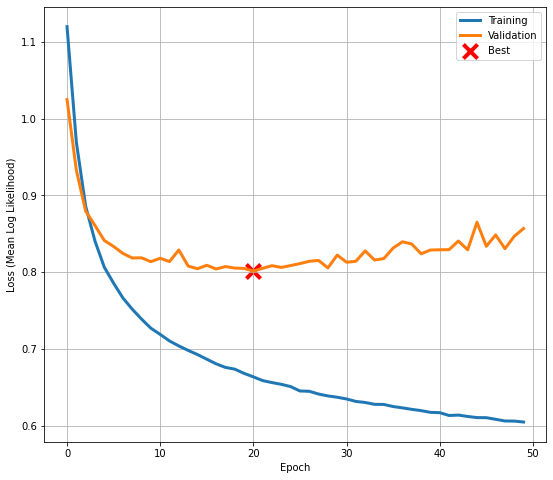

In [24]:
plt.plot(result.train_losses, linewidth=3, label='Training');
plt.plot(result.valid_losses, linewidth=3, label='Validation');
plt.scatter(
    (result.best_epoch,), (result.best_valid_loss,),
    s=200, linewidth=4, marker='x', color='red', label='Best');
plt.legend();
plt.grid();
plt.xlabel('Epoch');
plt.ylabel('Loss (Mean Log Likelihood)');

In [25]:
review_idx = np.random.randint(0, len(test_data))
[vocab.reverse.get(idx.item()) for idx in test_data[review_idx]], cnn_sentiment.text_labels(test_data[review_idx][None, :])

(['has',
  'created',
  'a',
  'masterful',
  'piece',
  'of',
  'artistry',
  'right',
  'here'],
 ['positive'])

In [26]:
phrases = [
    ['i', 'thought', 'the', 'new', 'star', 'wars', 'movie', 'was', 'great', 'and', 'excellent', '!'],
    ['movie', 'xyz', 'was', 'terrible', 'and', 'aweful', '!'],
    ['that', 'movie', 'was', 'just', 'ok', '.']
]
phrase_idxs = th.nn.utils.rnn.pad_sequence(
    [th.tensor([vocab[word] for word in phrase], dtype=th.int64) for phrase in phrases]).t()

cnn_sentiment.text_labels(phrase_idxs)

['somewhat positive', 'somewhat negative', 'somewhat negative']

## RNN Model

In [27]:
class RNNSentiment(th.nn.Module):
    '''A single-axis Convolutional Neural Network (CNN) with a max
    global pooling layer for sentiment analysis.
    
    Input:
        idxs:  th.Tensor(batch_size, ntokens, dtype=th.int64)
            A batch of phrases where each element is the integer
            index into the word embedding.
    
    Output:
        logits:  th.Tensor(batch_size, ncls)
            Visible layer outputs before application of the softmax
            function.  Larger values indicate a higher predicted
            confidence for a given class, i.e., sentiment level.
    '''
    def __init__(self, embed_weights, ncls, nrecurrent, ndense):
        '''Construct a new single-axis Convolutional Neural Network (CNN) with
        a max global pooling layer for sentiment analysis.
        
        Args:
            embed_weights:  th.Tensor(vocab_len, embed_dim, dtype=th.float32)
                Matrix of word vectors.  Note that the vocab length and
                embedding dimension are inferred from the shape of this matrix.
            ncls:
                Number of classes, i.e., sentiment levels.
            nconvs:  ((int, int), ...)
                An n-tuple of 2-tuples of integers representing the shapes
                of the convolutional layers.  The network will consist of
                n layers each specified as (nunits, kernel_size) where
                `nunits` is the number of convolutional filters or units
                and where `kernel_size` is the width of the convolution.
                Note that all convolutions are across a single axis.
            conv_transfer:  th.nn.Module
                The transfer function (aka activation function) applied
                to each convolutional layer.  Defaults to the Leaky
                Rectified Linear Unit, `th.nn.ReLU`.
            hidden_transfer:  th.nn.Module
                The transfer function (aka activation function) applied
                to the densely connected readout layer.  Defaults to
                the hyperbolic tangent, `th.nn.Tanh`.
        '''
        super().__init__()
        
        self.embed_dim = embed_weights.shape[1]
        self.ncls = ncls
        self.nrecurrent = nrecurrent
        self.ndense = ndense
 
        # initialize word embeddings and set `requires_grad = False` so
        # that the weights remain fixed during training
        self.word_embed = th.nn.Embedding.from_pretrained(embed_weights)
        self.word_embed.weight.requires_grad = False
                
        self.initial_state = th.nn.Parameter(
            th.empty(1, self.nrecurrent),
            requires_grad=True)
        th.nn.init.xavier_uniform_(self.initial_state)
        
        # construct the convolutional layers
        #self.rnn = th.nn.LSTM(self.embed_dim, self.nrecurrent)
        self.rnn = th.nn.RNN(self.embed_dim, self.nrecurrent)

        self.dense = th.nn.Sequential(
            th.nn.Linear(self.nrecurrent, self.ndense),
            th.nn.Tanh())
        
        self.visible = th.nn.Linear(self.ndense, self.ncls)
        
        self.softmax = th.nn.Softmax(1)
    
    def forward(self, idxs):
        '''Forward pass of RNN classifier.'''
        assert isinstance(idxs, th.nn.utils.rnn.PackedSequence)
        batch_size = idxs.batch_sizes.max().item()
        ntokens = len(idxs.batch_sizes)

        assert len(idxs.data.shape) == 1
                
        # word vectors are packed as (ntokens, batch_size, embed_dim)
        word_vectors = th.nn.utils.rnn.PackedSequence(
            self.word_embed(idxs.data), idxs.batch_sizes)
        assert word_vectors.batch_sizes.max().item() == batch_size
        assert len(word_vectors.batch_sizes) == ntokens
        assert len(word_vectors.data.shape) == 2
        assert word_vectors.data.shape[-1] == self.embed_dim
        
        initial_state = self.initial_state[None, ...].repeat(1, batch_size, 1)
        
        #_rnn_out, (state, _cell_state) = self.rnn(norm_vectors)
        _rnn_out, state = self.rnn(word_vectors, initial_state)
        state = state.squeeze(0)
        
        # FIXME: this is aweful slow, should handle sorting beforehand
        if idxs.unsorted_indices is not None:
            state = state[idxs.unsorted_indices]
        
        assert len(state.shape) == 2
        assert state.shape[0] == batch_size
        assert state.shape[1] == self.nrecurrent
        
        dense_out = self.dense(state)
        assert len(dense_out.shape) == 2
        assert dense_out.shape[0] == batch_size
        assert dense_out.shape[1] == self.ndense
        
        visible_out = self.visible(dense_out)
        assert len(visible_out.shape) == 2
        assert visible_out.shape[0] == batch_size
        assert visible_out.shape[1] == self.ncls
        
        return visible_out
    
    def probs(self, idxs):
        '''Predicted class membership probabilities for each phrase and class.'''
        return self.softmax(self(idxs))
    
    def labels(self, idxs):
        '''Predicted class labels for each phrase and class.'''
        return self(idxs).argmax(1)
    
    def text_labels(self, idxs):
        '''Predicted class labels, as a list of text strings, for each phrase.'''
        return [sentiment_labels[label.item()] for label in self(idxs).argmax(1)]

In [28]:
def collate_packed(data):
    phrases, labels = zip(*data)
    return th.nn.utils.rnn.pack_sequence(phrases, enforce_sorted=False), th.tensor(labels, dtype=th.int64)

In [29]:
rnn_sentiment = RNNSentiment(
    embed_weights=word_embed_weights,
    ncls=5,
    nrecurrent=64,
    ndense=8)

# the number of free parameters
sum(params.nelement() for params in rnn_sentiment.parameters() if params.requires_grad)

13045

In [30]:
result = train(rnn_sentiment, train_data, valid_data, max_epochs=50,
               learning_rate=0.00175, batch_size=512, collate_fn=collate_packed)

0 0.00175 1.0364055113358932 0.9338498884631742
10 0.001582668631265408 0.7563368723609231 0.7981913916526302
20 0.0014313371407951535 0.7176000367511403 0.786105634704713
30 0.0012944756534294904 0.6988856345956975 0.7957842388460713
40 0.0011707005774969402 0.6874795387007974 0.791048236431614


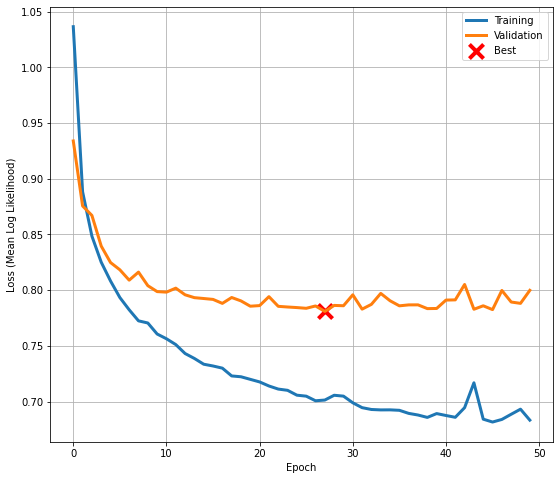

In [31]:
plt.plot(result.train_losses, linewidth=3, label='Training');
plt.plot(result.valid_losses, linewidth=3, label='Validation');
plt.scatter(
    (result.best_epoch,), (result.best_valid_loss,),
    s=200, linewidth=4, marker='x', color='red', label='Best');
plt.legend();
plt.grid();
plt.xlabel('Epoch');
plt.ylabel('Loss (Mean Log Likelihood)');

In [32]:
review_idx = np.random.randint(0, len(test_data))
[vocab.reverse.get(idx.item()) for idx in test_data[review_idx]], rnn_sentiment.text_labels(th.nn.utils.rnn.pack_sequence(test_data[review_idx][None, :]))

(['realistically', 'drawn', 'characterizations'], ['neutral'])